<h2> Infrastructure </h2>

In [ ]:
# Tips:  
  
# VSCode:
#    * Outline button is in the row of buttons right above this. Much easier navigation.
#    * Click on the blue bar to the left of a cell to hide it. Also works on outputs
#
# Jupyter Notebook:
#    * [View->Table of contents] for the outline
#    * You can click the arrow to the left of headings to collapse/expand their section
#
# Structure:
#    * The first code cell should run all the cells that simply define/import things
#    * The headings in the outline with an asterisk are the ones that actually use those functions, 
#      constants, and libraries to do things. You'll manually run those.
#    * Don't click the little "init" buttons in the bottom left of cells, it erases the tag
#
# Misc:
#    * [ctrl+Enter] runs a cell
#    * Select multiple lines of code, then press [ctrl+/] to comment or uncomment all 
#      (I just discovered this a couple months ago and am mad about it)

<h3>* Initialize All Functions and Libraries</h3>

In [9]:
# Turn on File->'Auto Save' if you want to use this. Reads cell data from disk.
# This runs every cell in here with the tag "init". Library imports and function definitions. Saves time when starting kernel.

import nbformat # Library for manipulating notebooks

def execute_cells_by_tag(group_tag, quiet=True):
    filepath = globals()['__vsc_ipynb_file__'] # Returns path to this file
    if (quiet==False): print(filepath)
    nb = nbformat.read(open(filepath, 'r', encoding='utf-8'), as_version=4) # Saves this notebook as JSON
    ip = get_ipython()                                                      # Gets the "global InteractiveShell instance"
    if (quiet==False): print(ip)
    for cell_number in range(len(nb.cells)):
        cell=nb.cells[cell_number]
        #print(cell)
        if 'tags' in cell.metadata:
            if group_tag in cell.metadata.tags:
                ip.run_cell(cell.source)
                if (quiet==False): print(f"Ran Cell {cell_number}")

execute_cells_by_tag('init')

# All outputs will be printed here
# This code is janky and might depreciate fast
# Only other way to do this would be through javascript - I had kernal issues. I don't think VSCode supports switching between javascript and python in the middle of running code
# Or an extension, but the ones that do this are more obscure (and seem poorly written) and I don't want to download malicious code to UT's network

Imported Libraries
ICASL is loaded!
Initialized Constants:
VIN: [1.8, 1.775, 1.75, 1.725, 1.7, 1.675, 1.65, 1.625, 1.6, 1.575, 1.55, 1.525, 1.5, 1.475, 1.45, 1.425, 1.4, 1.375, 1.35, 1.325, 1.3, 1.275, 1.25, 1.225, 1.2, 1.175, 1.15, 1.125, 1.1, 1.075, 1.05, 1.025, 1.0]
VREF: [0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3]
IL (mA): [ 0.1  0.3  0.5  1.   2.   3.   4.   5.   6.   7.   8.   9.  10. ]
Initialized Equipment's Establish Connection
Initialized Equipment Functions
Initialized Plotting Default Styling
Initialized Specific Plots
Initialized Individual Tests
Initialized Full Procedure


<h3> Import Libraries </h3>

In [ ]:
# Testing/Plotting Code for PMOS_LDO
# Written by Shawn Newman (with a lot of code from Langdon Skarda)

import pyvisa                    # Instrument communication
import time                      # Handle time-related tasks (e.g., delays)
import matplotlib.pyplot as plt  # Plotting graphs and visualizing data
from matplotlib.ticker import LogLocator # Used for ticks in logarithmic plots
import numpy as np               # Numerical operations, particularly with arrays
import pandas as pd              # Data manipulation and analysis
import os                        # Interact with the operating system, such as handling file paths
from datetime import date        # Read current date
from collections import defaultdict
import importlib.util            # Used to load python files more dynamically

print("Imported Libraries")

Imported Libraries


In [ ]:
# import ICASL
# print("Imported ICASL from this directory")

In [7]:
# Loads ICASL.py from a higher directory
quiet=True
current_dir = "."
target_file = "ICASL.py"
target_name = "ICASL"
while True:
    if not quiet: print(current_dir)
    # Check if ICASL is in the current directory
    ICASL_path = os.path.join(current_dir, target_file)
    if not quiet: print(ICASL_path)
    if os.path.isfile(ICASL_path):
        # Loads ICASL.py
        spec = importlib.util.spec_from_file_location(target_name, ICASL_path)
        ICASL = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(ICASL)
        break
    else:
        # Move one level up
        parent_dir = os.path.join(current_dir, "..")
        if not quiet: print(parent_dir)
        if current_dir == parent_dir:  # Reached the root directory
            raise ValueError("ICASL.py not found")
        else:
            current_dir = parent_dir
ICASL.test()

ICASL is loaded!


<h3> Constants </h3>

In [ ]:
DEVICE_NAME = "PMOS_LDO" # GLOBAL directory
SET_PRECISION = .2  # How close the probe's temperature needs to get to the SET value before soak time begins (in Celsius)
SETTLING_TIME = .25 # How long to wait before setting values and measuring (in seconds)
# Required SETTLING_TIME will vary depending on the circuit. If there's a lot of sweeps, it can make the tests take much longer.
SOAK_TIME = 300     # How long to soak at temperature (in seconds)

print("Initialized Constants:")

# Circuit Values
RHI = 264.3
RLO = 68000

# Defaults
IL_DEFAULT = .003
VIN_DEFAULT = 1.8
VREF_DEFAULT = .8

# Sweeps
VIN_MAX = 1.8
VIN_STEP = -.025
VIN_MIN = 1
# Full VIN list isn't created until the tests, since the minimum value will change.
VIN_example_list = ICASL.arange(VIN_MAX, VIN_MIN, VIN_STEP)
print(f"VIN: {VIN_example_list}")

VREF_MAX = .85
VREF_STEP = -.05
VREF_MIN = .3
GLOBAL_VREFS = ICASL.arange(VREF_MAX, VREF_MIN, VREF_STEP)
print(f"VREF: {GLOBAL_VREFS}")

GLOBAL_TEMPS = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, -175]

GLOBAL_ILS = [100E-6, 300E-6, 500E-6, 1E-3, 2E-3, 3E-3, 4E-3, 5E-3, 6E-3, 7E-3, 8E-3, 9E-3, 10E-3]
GLOBAL_ILS_mA = ICASL.scale(GLOBAL_ILS)
print(f"IL (mA): {GLOBAL_ILS_mA}")

Initialized Constants:
VIN: [1.8, 1.775, 1.75, 1.725, 1.7, 1.675, 1.65, 1.625, 1.6, 1.575, 1.55, 1.525, 1.5, 1.475, 1.45, 1.425, 1.4, 1.375, 1.35, 1.325, 1.3, 1.275, 1.25, 1.225, 1.2, 1.175, 1.15, 1.125, 1.1, 1.075, 1.05, 1.025, 1.0]
VREF: [0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3]
VREF Precision: 2
IL (mA): [ 0.1  0.3  0.5  1.   2.   3.   4.   5.   6.   7.   8.   9.  10. ]
0.8


<h2> Equipment </h2>

In [3]:
# Enable full pyvisa logging
pyvisa.log_to_screen()

In [ ]:
# Disable full pyvisa logging
import logging
pyvisa.log_to_screen(level=logging.INFO)

<h3>* Find available devices </h3>

In [2]:
rm = pyvisa.ResourceManager()    # Create a ResourceManager object, which manages communication with instruments
rm.list_resources()              # List all available resources (e.g., connected instruments) managed by pyvisa

('ASRL3::INSTR',
 'ASRL4::INSTR',
 'GPIB6::6::INSTR',
 'USB0::0x0957::0x0607::MY45002108::0::INSTR',
 'USB0::0x0957::0x1796::MY57231548::0::INSTR',
 'USB0::0x0957::0x1796::MY57231553::0::INSTR',
 'USB0::0x0957::0x17B6::MY56310504::0::INSTR',
 'USB0::0x0957::0x2C07::MY57890777::0::INSTR',
 'USB0::0x0957::0x5707::MY53802060::0::INSTR',
 'USB0::0x2A8D::0x0101::MY54505624::0::INSTR',
 'USB0::0x2A8D::0x0101::MY57508183::0::INSTR')

In [ ]:
# TODO: ADD POWER SUPPLIES TO TESTING CODE (need physical connections first)

def establish_connection(address, query):
    instrument = rm.open_resource(address)   # Open a connection to the instrument with the address and assign it to SM_VIN
    instrument.read_termination = '\n'       # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
    instrument.write_termination = '\n'      # Set the write termination character to a newline. This ensures that each command sent to the instrument is properly terminated.
    instrument.baud_rate = 9600              # Set the baud rate for serial communication to 9600. This is the speed at which data is transmitted over the serial connection.
    print(instrument)                        # Print the resource object to display its properties
    if query != "NONE":
        print(instrument.query(query))           # Send the query to the instrument and print its response. This command usually asks the instrument to identify itself (e.g., manufacturer, model number).
    return instrument

print("Initialized Equipment's Establish Connection")

<h3>* Connect Equipment </h3>

In [ ]:
# Corresponding voltages/currents are in the names of equipment
# For a device with multiple channels, list each channel's voltage/current in order
# Everything except the temp chamber needs to be powered on beforehand.

SM_VIN = establish_connection('GPIB6::20::INSTR', '*IDN?') # Also measures current, through VIN
MM_VOUT = establish_connection('USB0::10893::257::MY57508183::0::INSTR', '*IDN?')
MM_VDROP = establish_connection('USB0::0x2A8D::0x0101::MY54505624::INSTR', '*IDN?')
WG_VREF_VISET = establish_connection('USB0::2391::22279::MY53802060::0::INSTR', '*IDN?') # If you connect WGs twice you may need to restart your IDE
CHAMBER = establish_connection('GPIB6::6::INSTR', 'STATUS?')

SerialInstrument at ASRL4::INSTR
GPIBInstrument at GPIB6::20::INSTR
KEITHLEY INSTRUMENTS INC.,MODEL 2401,4636506,B02 Jan 20 2021 10:19:49/B01  /W/N
USBInstrument at USB0::10893::257::MY57508183::0::INSTR
Keysight Technologies,34465A,MY57508183,A.02.17-02.40-02.17-00.52-04-01
USBInstrument at USB0::0x2A8D::0x0101::MY54505624::0::INSTR
Keysight Technologies,34465A,MY54505624,A.02.14-02.40-02.14-00.49-02-01
USBInstrument at USB0::2391::22279::MY53802060::0::INSTR
Agilent Technologies,33622A,MY53802060,A.01.11-2.25-03-64-02
GPIBInstrument at GPIB6::6::INSTR
NNNNNNNNNNNNNNNNNN0


VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

Equipment Info

In [ ]:
# To find IDs

# Waveform Generators: System -> I/O Settings -> USB
# Multimeters:
# SourceMeters:
# Sun Chamber: 'GPIB6::6::INSTR'

# Temperature Chamber Status

# Y = power is on
# 2: Y = command error last command
# 3: Y = time out LED is on
# 4: Y = waiting for timeout
# 5: Y = heat output is enabled
# 6: Y = cool output is enabled
# 7: Y = valid set temperature
# 8: Y = deviation limit exceeded
# 9: Y = currently ramping
# 10: Y = chamber temp < lower limit
# 11: Y = chamber temp > upper limit
# 12: Y = waiting at a BKPNT
# 13: Y = in LP run mode
# 14: Y = in LP remote store mode
# 15: Y = in local edit LP mode
# 16: Y = waiting to run LP at TOD
# 17: Y = GPIB bus timeout
# 18: Y = in local keyboard lockout mode
# 19: 0 = system Self Test was OK
# 1 = Battery RAM error found (check default settings)
# 2 = EE RAM error found (check probe calibration)
# 3 = ROM error found (call factory)

<h3> Equipment Functions </h3>

In [ ]:
####### Temperature Chamber #######

def chamber_init():
    CHAMBER.write("ON")                 # Also turns on heat and cool (unless configured otherwise)
    CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change temp
    CHAMBER.write("WAIT=FOREV")         # Sets the time that the chamber will wait once the desired temperature is reached before moving to next temp. We don't use this.
    CHAMBER.write("HON")                # Turns heat on (just in case)
    CHAMBER.write("CON")                # Turns cool on (just in case)
    CHAMBER.write("PIDA=3")             # Switches to monitoring user probe when setting temperature (DUT will reach temperature, not the top of the chamber)
    time.sleep(1) 
    #print(CHAMBER.query("RATE?"))
    #print(CHAMBER.query("WAIT?"))

####### SMU #######

# TODO: Figure out when SCPI needs leading colons

def SM_init(SM):
    SM.write(":CONF:CURR")                  # Configure the SMU to measure current
    SM.write("OUTP:STAT 0")                 # Turn off the VIN source meter
    SM.write("SOUR:VOLT:RANG 1.8")
    SM.write("SENS:CURR:PROT:LEV 0.0105")   # Set the current protection level (compliance) to 10.5 mA. This limits the maximum current to protect the device under test.
    SM.write("SENS:CURR:RANG 1E-2")         # Set the current measurement range to 10 mA. This sets the expected maximum current for accurate measurement.
    SM.timeout = 100000                     # Set the timeout for the SMU operations to 100,000 milliseconds (100 seconds).
    SM.write("CURR:NPLC 10")
    SM.write("SYST:BEEP:STAT OFF")           # Turn off the beeper on the SMU

def SM_on(SM, val):
    SM.write(":SOUR:VOLT:MODE FIX")
    SM.write(f"SOUR:VOLT:LEV {val}")
    SM.write("OUTP ON")

def SM_off(SM):
    SM.write("SOUR:VOLT:LEV 0")
    SM.write("OUTP:STAT 0")

####### MM #######

def MM_init(MM):
    MM.write(":CONF:VOLT:DC")
    MM.write("VOLT:DC:RANG 10")
    MM.write("VOLT:NPLC 10")

####### WG #######

def WG_init(WG):
    WG.write("OUTP1:LOAD DEF")          # Sets the output load to infinite so no impedance matching is necessary
    WG.write("OUTP2:LOAD DEF")
    WG.write("SOUR1:APPL:DC")          # Sets the Waveform generator to output a DC voltage
    WG.write("SOUR2:APPL:DC")          # Sets the Waveform generator to output a DC voltage

def WG_on(WG, channel, val):
    if (channel != 1 and channel != 2):
        print("Invalid channel")
        return -1
    WG.write(f"SOUR{channel}:APPL:DC DEF, DEF, {val}")
    WG.write(f"OUTP{channel}:STAT 1")

def WG_off(WG, channel):
    if (channel != 1 and channel != 2):
        print("Invalid channel")
        return -1
    WG.write(f"SOUR{channel}:APPL:DC DEF, DEF, 0")
    WG.write(f"OUTP{channel}:STAT 0")

####### Groupings #######
# Do not affect temperature chamber

def initialize_all():
    SM_init(SM_VIN)
    MM_init(MM_VOUT)
    MM_init(MM_VDROP)
    WG_init(WG_VREF_VISET) 

def turn_on_all():
    time.sleep(1) 
    WG_on(WG_VREF_VISET, 1, VREF_DEFAULT)
    SM_on(SM_VIN, 1.8)            # Turn on the VIN source meter output
    time.sleep(.5)
    VISET = VISET = VISET_calc(VREF_DEFAULT, IL_DEFAULT)
    WG_on(WG_VREF_VISET, 2, VISET)  # Turn on the WG for VISET to set IL to default for the first VREF so that it can warm up while CHAMBER starts

def turn_off_all():
    WG_off(WG_VREF_VISET, 2)    # Turn off VISET first!!!
    time.sleep(.5)
    SM_off(SM_VIN)             # Turn off the VIN source meter
    WG_off(WG_VREF_VISET, 1)    # Turn off VREF

def measure_all():
    MM_VOUT.query(":READ?")
    MM_VDROP.query(":READ?")
    SM_VIN.query(":READ?")

print("Initialized Equipment Functions")

Initialized Equipment Functions


<h3>* Test Equipment </h3>

In [ ]:
# Test Multimeters
MM_init(MM_VOUT)
print(MM_VOUT.query(":CONF?"))
print(MM_VOUT.query(":READ?"))

MM_init(MM_VDROP)
print(MM_VDROP.query(":CONF?"))
print(MM_VDROP.query(":READ?"))

In [ ]:
# Test SourceMeter
SM_init(SM_VIN)
print(SM_VIN.query(":CONF?"))

In [ ]:
# Test Waveform Generator?
WG_init(WG_VREF_VISET)
#print(WG_VREF_VISET.query(":CONF?")) # Doesn't seem to work

In [ ]:
turn_on_all()

In [ ]:
measure_all()

In [ ]:
turn_off_all()

<h2> Plotting </h2>

<h3> Default Styling </h3>

In [3]:
# ICASL.start_plot() defines global default plotting parameters. Has a couple styles built in.
# local_start_plot() defines default plotting parameters for this specific file. So if you want to change something about all of these
# plots, you could either add code before the call to ICASL or eliminate the call to ICASL and write your own function entirely.

def local_start_plot(title, xlabel, ylabel):
    fig, ax = ICASL.start_plot(title, xlabel, ylabel)
    return fig, ax

def local_finish_plot(fig, ax, save_dir="none", save_file="none", cm=plt.get_cmap('gist_rainbow'), legend=None, legend_style="None", annotations=None, close=True, show=False):
    legend = ax.legend(bbox_to_anchor=(1.02, 1))
    legend_style = "b"
    ICASL.finish_plot(fig, ax, save_dir=save_dir, cm=cm, save_file=save_file, legend=legend, legend_style=legend_style, annotations=annotations, close=close, show=show)

print("Initialized Plotting Default Styling")

Initialized Plotting Default Styling


<h3> Specific Plots </h3>

In [ ]:
################## Initialize and format plots ##################

def dropout_voltage_plot_init():
    fig, ax = local_start_plot('Dropout Voltage', 'Temperature (°C)', f'Vdo(Vin-Vout) (mV)')
    ax.set_xticks(ICASL.arange(-150, 100, 50))
    #DVplot.set_yticks(np.arange(0, 1.3, 0.1))
    #DVplot.set_ylim(-175, 125)
    return fig, ax

def dropout_voltage_plot(read_dir, write_dir, plot_temps, plot_VREFs):
    fig, ax = dropout_voltage_plot_init()
    VREFs = plot_VREFs
    # Can't find dropout voltage from plots under VREF=.55
    VREFs = [VREF for VREF in VREFs if VREF > .5]
    for i, VREF in enumerate(VREFs):
        VDOs = []
        for temp in plot_temps:
            #df = pd.read_csv(os.path.join(read_dir, f"_{temp}", f"VIN_Sweep_VREF={ICASL.set_precision(VREF, plot_VREFs)}.csv"))
            df = pd.read_csv(os.path.join(read_dir, f"TEMP_{temp}", f"VIN_Sweep_VREF={VREF}.csv"))
            #df = VIN_sweep[temp][VREF]['VOUT'].values
            csv_VOUTs = df['VOUT'].values #.values converts to a numpy array. Needed here because of following calculations
            csv_VINs = df['VIN'].values
            vout_max = np.max(csv_VOUTs)
            drop_threshold = 0.90 * vout_max  # 10% drop threshold
            drop_index = np.argmax(csv_VOUTs < drop_threshold) # Returns first occcurance of maximum value (True)
            if drop_index > 0:
                vin_drop = csv_VINs[drop_index]
                vout_drop = csv_VOUTs[drop_index]
            else:
                vin_drop = csv_VINs[-1]
                vout_drop = csv_VOUTs[-1]
                print("Warning: Couldn't find value within dropout threshold.")
            dropout = vin_drop - vout_drop
            VDOs.append(dropout)
        ax.plot(plot_temps, ICASL.scale(VDOs), label=f"VREF={VREF} V")
    local_finish_plot(fig, ax, save_dir=write_dir, save_file=f"Dropout_Voltage.png")


def voltage_regulation_plot_init():
    fig, ax = local_start_plot('Vout Regulation at Vin=1.8V', 'Temperature (°C)', 'Vout (V)')
    ax.set_xticks(ICASL.arange(-150, 100, 50))
    return fig, ax

#X-axis is split between directories
def voltage_regulation_plot(read_dir, write_dir, plot_temps, plot_VREFs):
    fig, ax = voltage_regulation_plot_init()
    for VREF in plot_VREFs:
        VOUTlist = []
        for temp in plot_temps:
            #df = pd.read_csv(os.path.join(read_dir, f"temp_{temp}", f"VIN_Sweep_VREF={ICASL.set_precision(VREF, plot_VREFs)}.csv"))
            df = pd.read_csv(os.path.join(read_dir, f"TEMP_{temp}", f"VIN_Sweep_VREF={VREF}.csv"))
            VOUTlist.append(df['VOUT'].iloc[0])
        ax.plot(plot_temps, VOUTlist, label=f"VREF={VREF} V")
    local_finish_plot(fig, ax, save_dir=write_dir, save_file=f"Voltage_Regulation.png")
                      #annotations=r"$VOUT_{IDEAL}$=2$\times$VREF")


def line_regulation_plot_init(VREF):
    fig, ax = local_start_plot(f'Line Regulation at VREF={VREF}V', 'Vin (V)', 'Vout (V)')
    ax.set_xticks(ICASL.arange(max(VIN_MIN, VREF), 1.8, 0.1))
    return fig, ax

def line_regulation_plots(read_dir, write_dir, plot_temps, plot_VREFs):
    for VREF in plot_VREFs:
        fig, ax = line_regulation_plot_init(VREF)
        for temp in plot_temps:
            #df = pd.read_csv(os.path.join(read_dir, f"VIN_Sweep_VREF={ICASL.set_precision(VREF, plot_VREFs)}.csv"))
            df = pd.read_csv(os.path.join(read_dir, f"TEMP_{temp}", f"VIN_Sweep_VREF={VREF}.csv"))
            ax.set_xticks(ICASL.arange(min(df["VIN"]), 1.8, 0.1))
            ax.set_xlim(min(df["VIN"]), 1.8)
            ax.plot(df['VIN'], df['VOUT'], label=f"T={temp} °C")
        local_finish_plot(fig, ax, save_dir=write_dir, save_file=f"Line_Regulation_{ICASL.set_precision(VREF, plot_VREFs)}V.png") 
                         #annotations=r"$VOUT_{IDEAL}$=2$\times$VREF")


def load_regulation_plot_init(VREF):
    fig, ax = local_start_plot(f'Load Regulation at VREF={VREF}V', 'IL (mA)', 'Vout (V)')
    ax.set_xscale('log')
    ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
    return fig, ax

def load_regulation_plots(read_dir, write_dir, plot_temps, plot_VREFs):
    for VREF in plot_VREFs:
        fig, ax = load_regulation_plot_init(VREF)
        for temp in plot_temps:
            #df = pd.read_csv(os.path.join(read_dir, f"temp_{temp}", f"VIN_Sweep_VREF={ICASL.set_precision(VREF, plot_VREFs)}.csv"))
            df = pd.read_csv(os.path.join(read_dir, f"TEMP_{temp}", f"IL_Sweep_VREF={VREF}.csv"))
            ax.plot(GLOBAL_ILS_mA, df['VOUT'], label=f"T={temp} °C")
        local_finish_plot(fig, ax, save_dir=write_dir, save_file=f"Load_Regulation_{ICASL.set_precision(VREF, plot_VREFs)}V.png")
                      #annotations=r"$VOUT_{IDEAL}$=2$\times$VREF")


def cold_start_line_regulation_plot_init():
    fig, ax = local_start_plot('Line Regulation Cold Start at T=-175 °C', 'Vin (V)', 'Vout (V)')
    ax.set_xticks(ICASL.arange(VIN_MIN, 1.8, 0.1))
    return fig, ax

def cold_start_line_regulation_plot(read_dir, write_dir, plot_VREFs):
    fig, ax = cold_start_line_regulation_plot_init()
    for VREF in plot_VREFs:
        #df = pd.read_csv(os.path.join(read_dir, f"temp_-175C_Cold_Start", f"VIN_Sweep_VREF={ICASL.set_precision(VREF, plot_VREFs)}.csv"))
        df = pd.read_csv(os.path.join(read_dir, f"TEMP_-175C_Cold_Start", f"VIN_Sweep_VREF={VREF}.csv"))
        ax.plot(df['VIN'], df['VOUT'], label=f"VREF={VREF} V")
    local_finish_plot(fig, ax, save_dir=write_dir, save_file=f"Line_Regulation.png", 
                      legend=ax.legend(bbox_to_anchor=(1.02, 1)))
                      #annotations=r"$VOUT_{IDEAL}$=2$\times$VREF")


def cold_start_load_regulation_plot_init():
    fig, ax = local_start_plot('Load Regulation Cold Start at T=-175 °C', 'IL (mA)', 'Vout (V)')
    #plot.set_xticks(np.arange(-1, 10+1, 1))
    ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
    ax.set_xscale('log')
    return fig, ax

def cold_start_load_regulation_plot(read_dir, write_dir, plot_VREFs):
    fig, ax = cold_start_load_regulation_plot_init()
    for VREF in plot_VREFs:
        #df = pd.read_csv(os.path.join(read_dir, f"temp_-175C_Cold_Start", f"IL_Sweep_VREF={ICASL.set_precision(VREF, plot_VREFs)}.csv"))
        df = pd.read_csv(os.path.join(read_dir, f"TEMP_-175C_Cold_Start", f"IL_Sweep_VREF={VREF}.csv"))
        ax.plot(GLOBAL_ILS_mA, df['VOUT'], label=f"VREF={VREF} V")
    local_finish_plot(fig, ax, save_dir=write_dir, save_file=f"Load_Regulation.png")
                      #annotations=r"$VOUT_{IDEAL}$=2$\times$VREF")


def reverse_line_regulation_plot_init(temp):
    fig, ax = local_start_plot(f'Line Regulation at T={temp} °C', 'Vin (V)', 'Vout (V)')
    ax.set_xticks(ICASL.arange(VIN_MIN, 1.8, 0.1))
    return fig, ax

def reverse_line_regulation_plot(read_dir, write_dir, plot_temps, plot_VREFs):
    for temp in plot_temps:
        fig, ax = reverse_line_regulation_plot_init(temp)
        for VREF in plot_VREFs:
            #df = pd.read_csv(os.path.join(read_dir, f"temp_-175C_Cold_Start", f"VIN_Sweep_VREF={ICASL.set_precision(VREF, plot_VREFs)}.csv"))
            df = pd.read_csv(os.path.join(read_dir, f"TEMP_{temp}", f"VIN_Sweep_VREF={VREF}.csv"))
            ax.plot(df['VIN'], df['VOUT'], label=f"VREF={VREF} V")
        local_finish_plot(fig, ax, save_dir=write_dir, save_file=f"Line_Regulation_{ICASL.set_precision(temp, plot_temps)}°C.png")
                      #annotations=r"$VOUT_{IDEAL}$=2$\times$VREF")


def reverse_load_regulation_plot_init(temp):
    fig, ax = local_start_plot(f'Load Regulation at T={temp} °C', 'IL (mA)', 'Vout (V)')
    ax.set_xscale('log')
    ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
    return fig, ax

def reverse_load_regulation_plot(read_dir, write_dir, plot_temps, plot_VREFs):
    for temp in plot_temps:
        fig, ax = reverse_load_regulation_plot_init(temp)
        for VREF in plot_VREFs:
            #df = pd.read_csv(os.path.join(read_dir, f"temp_-175C_Cold_Start", f"IL_Sweep_VREF={ICASL.set_precision(VREF, plot_VREFs)}.csv"))
            df = pd.read_csv(os.path.join(read_dir, f"TEMP_{temp}", f"IL_Sweep_VREF={VREF}.csv"))
            ax.plot(GLOBAL_ILS_mA, df['VOUT'], label=f"VREF={VREF} V")
        local_finish_plot(fig, ax, save_dir=write_dir, save_file=f"Load_Regulation_{ICASL.set_precision(temp, plot_temps)}°C.png", 
                      legend=ax.legend(bbox_to_anchor=(1.02, 1)))
                      #annotations=r"$VOUT_{IDEAL}$=2$\times$VREF")


def plot_all_across_temps(read_dir, write_dir, plot_temps, plot_VREFs):
    dropout_voltage_plot(read_dir, write_dir, plot_temps, plot_VREFs)
    voltage_regulation_plot(read_dir, write_dir, plot_temps, plot_VREFs)
    
    line_regulation_plots(read_dir, write_dir, plot_temps, plot_VREFs)
    load_regulation_plots(read_dir, write_dir, plot_temps, plot_VREFs)

#Occurs at one temperature, doesn't need temps
def plot_all_cold_start(read_dir, write_dir, plot_VREFs):
    cold_start_line_regulation_plot(read_dir, write_dir, plot_VREFs)
    cold_start_load_regulation_plot(read_dir, write_dir, plot_VREFs)

def plot_all_reverse(read_dir, write_dir, plot_temps, plot_VREFs):
    reverse_line_regulation_plot(read_dir, write_dir, plot_temps, plot_VREFs)
    reverse_load_regulation_plot(read_dir, write_dir, plot_temps, plot_VREFs)

print("Initialized Specific Plots")

Initialized Specific Plots


<h3>* Preview Plot Formatting </h3>

c:\Users\spnew\Documents\Employment\Testing Code\ICASL_test_code\NASA\PMOS_LDO\..\..\ICASL.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(layout='constrained')


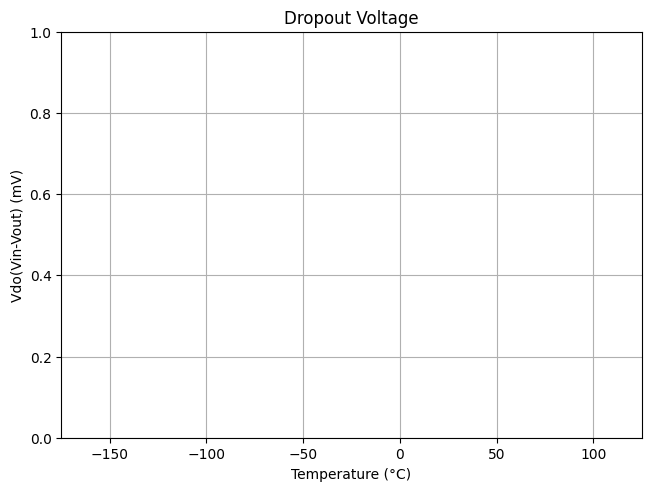

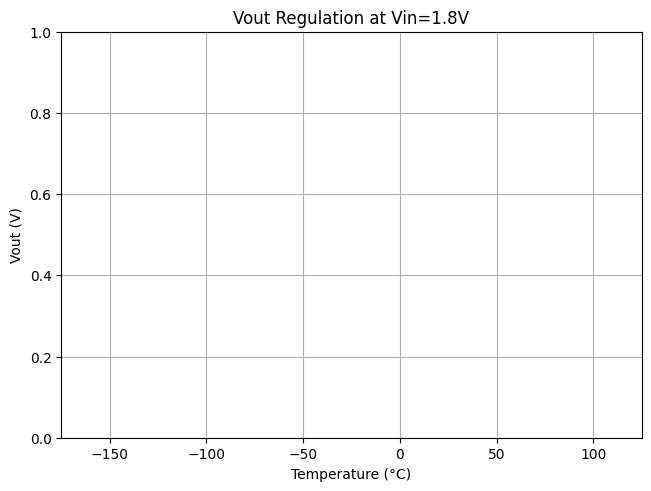

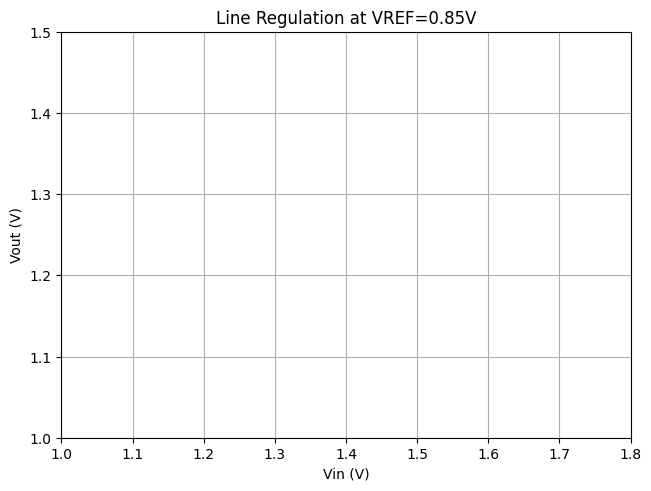

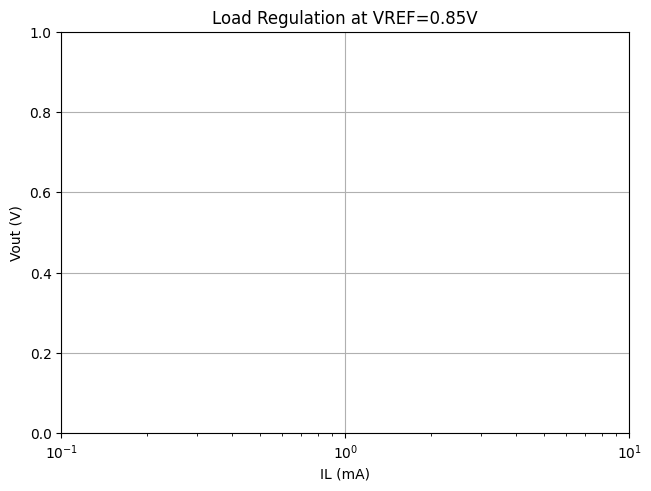

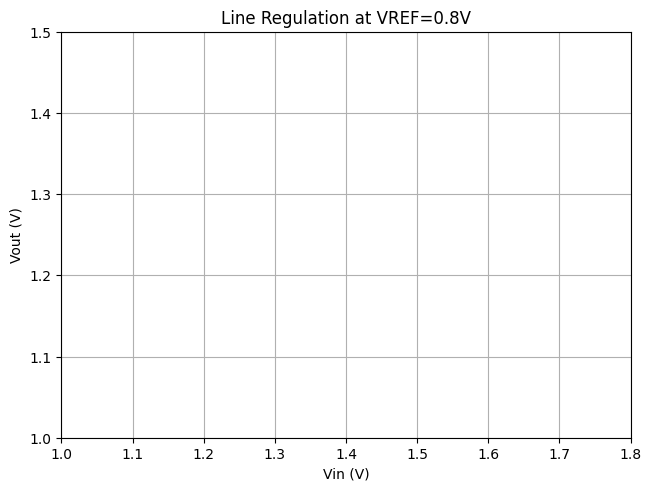

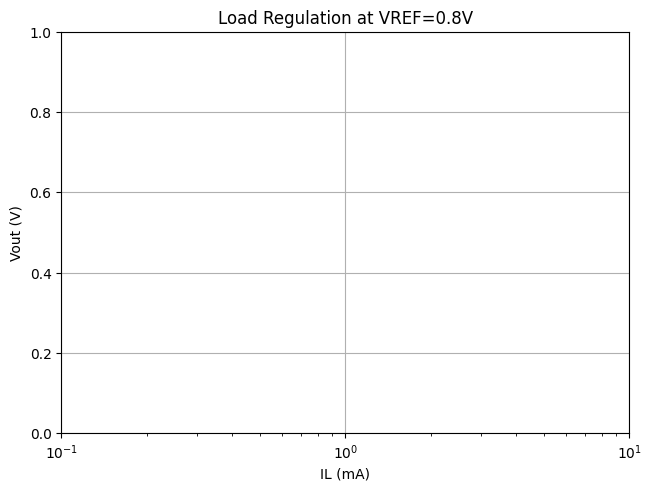

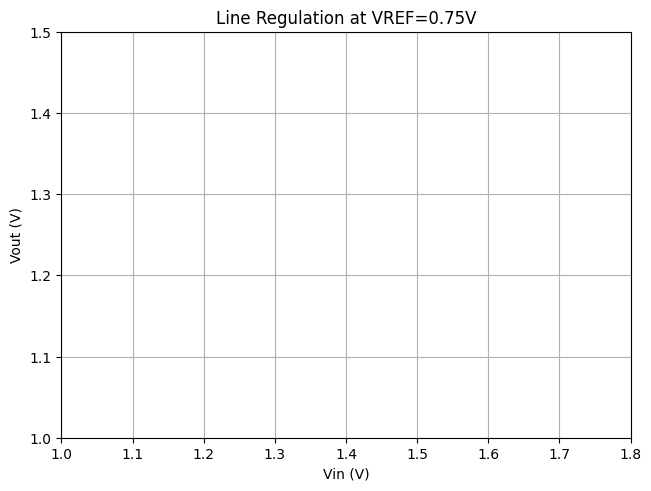

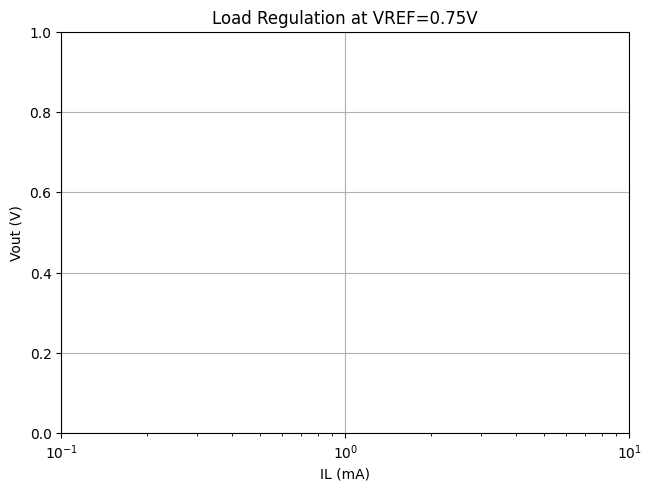

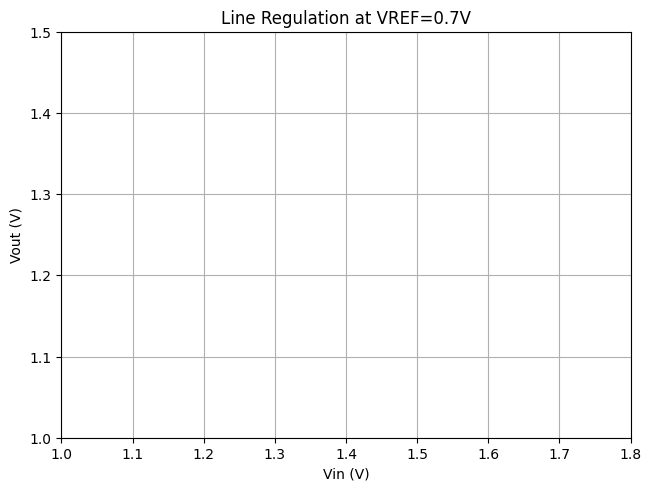

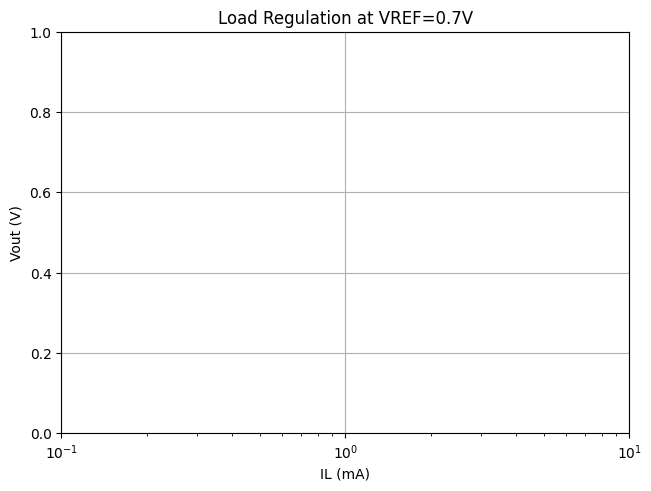

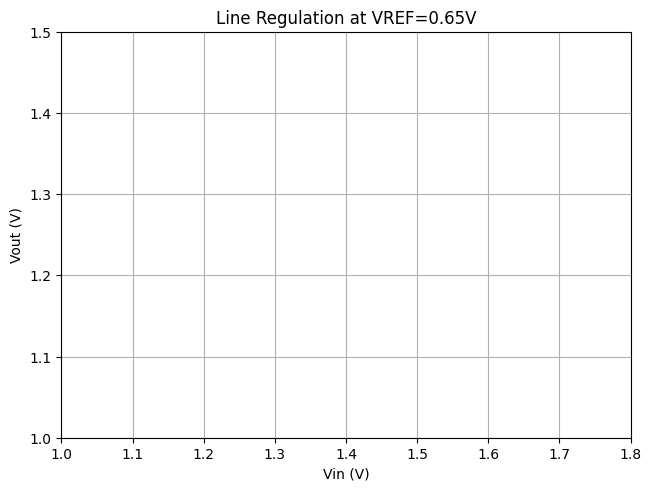

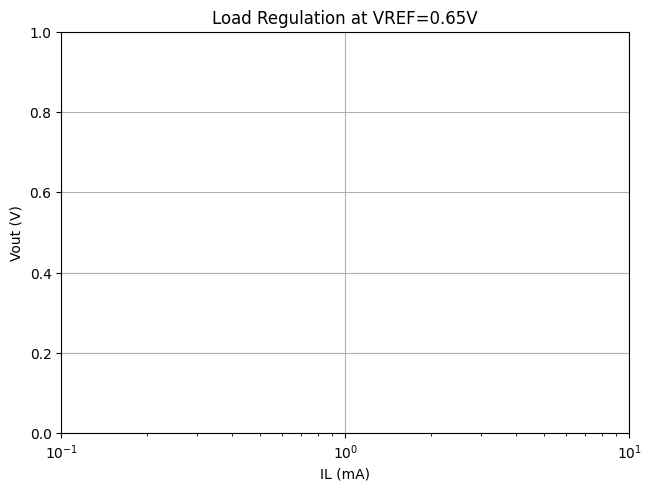

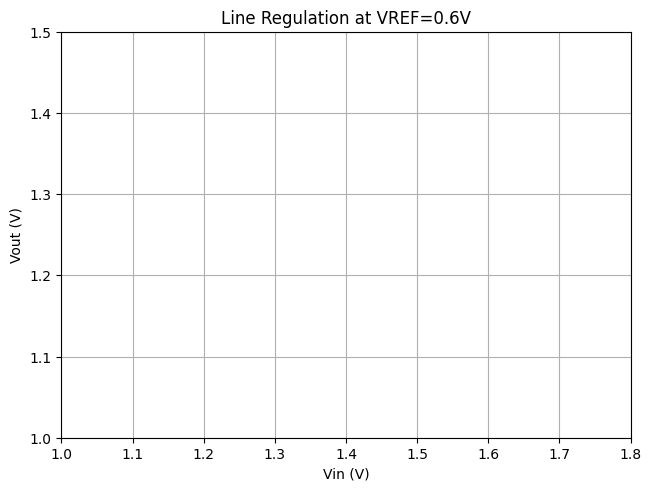

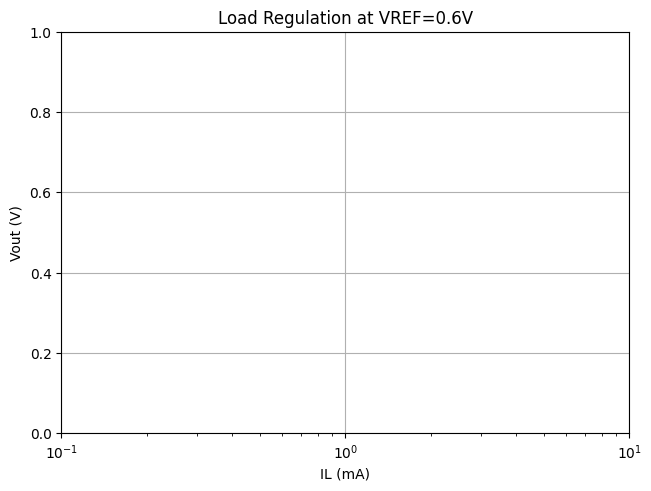

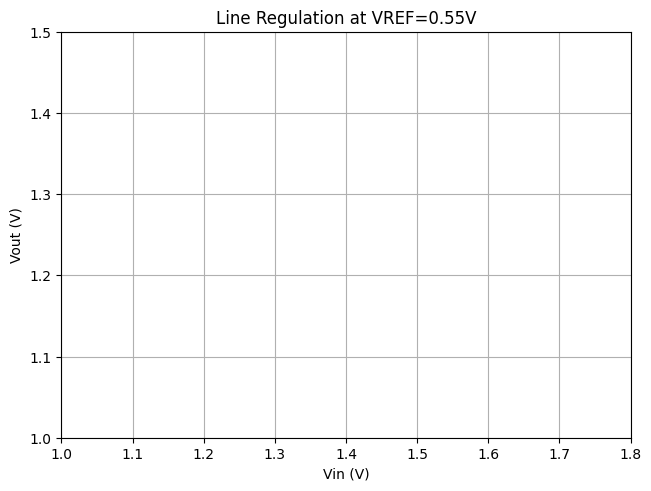

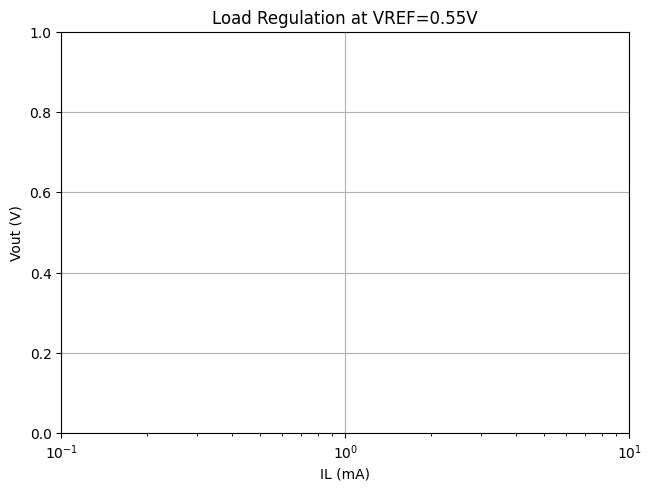

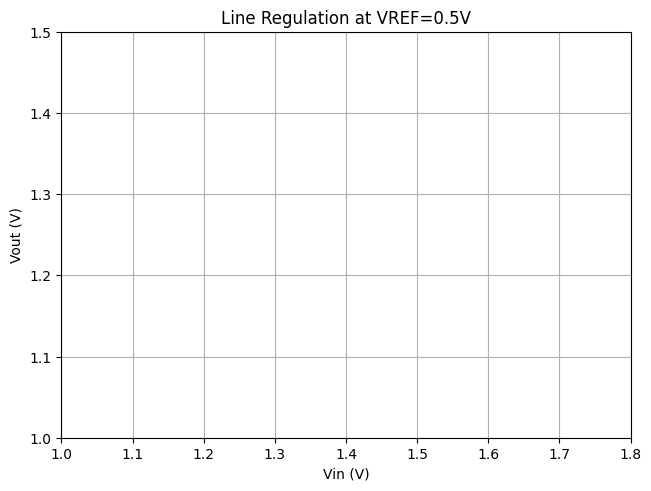

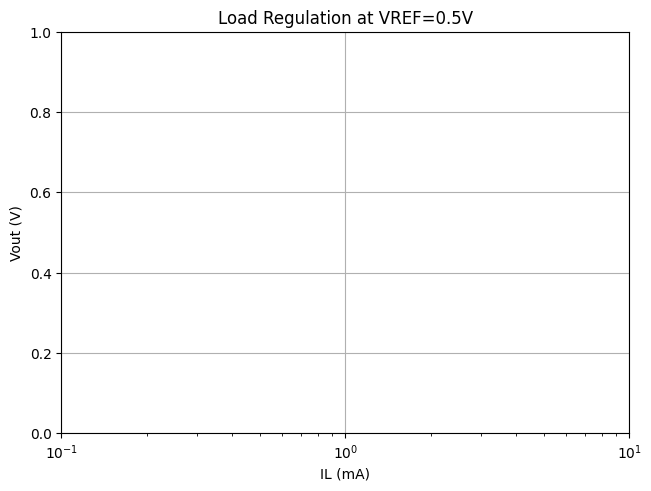

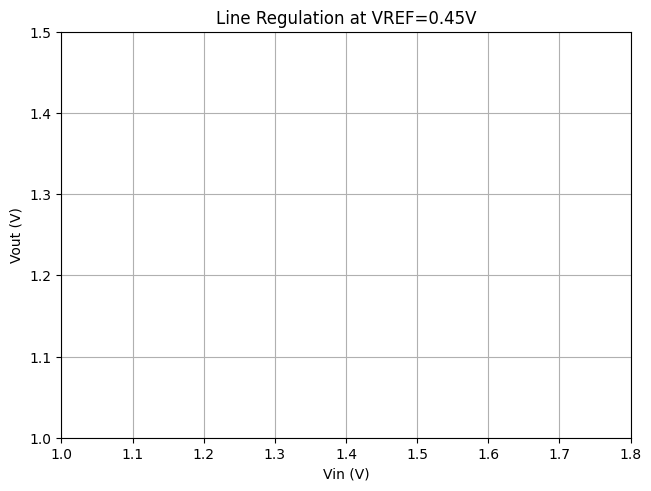

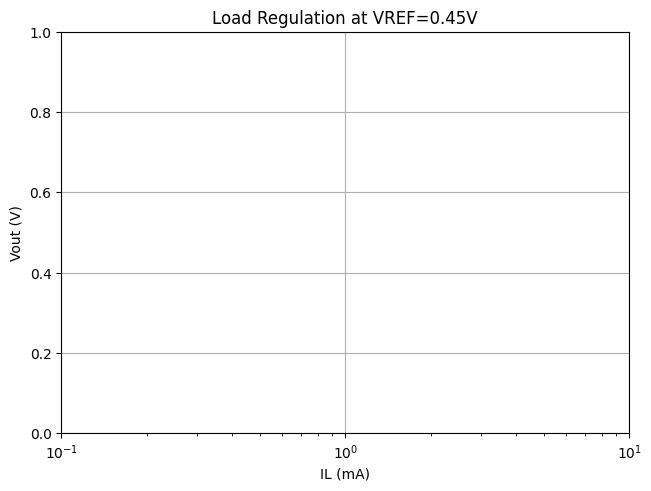

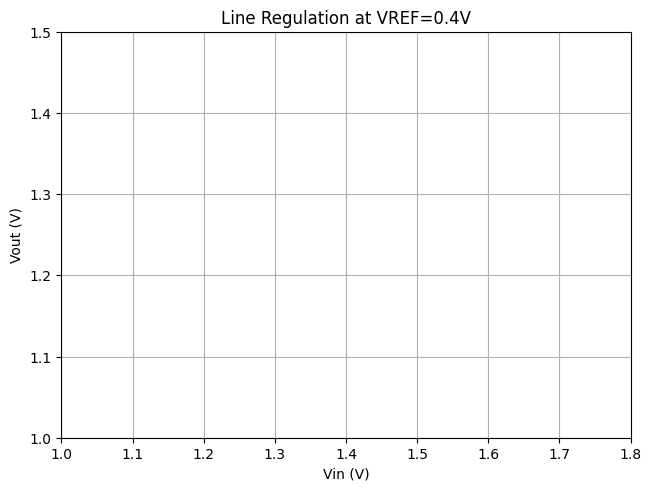

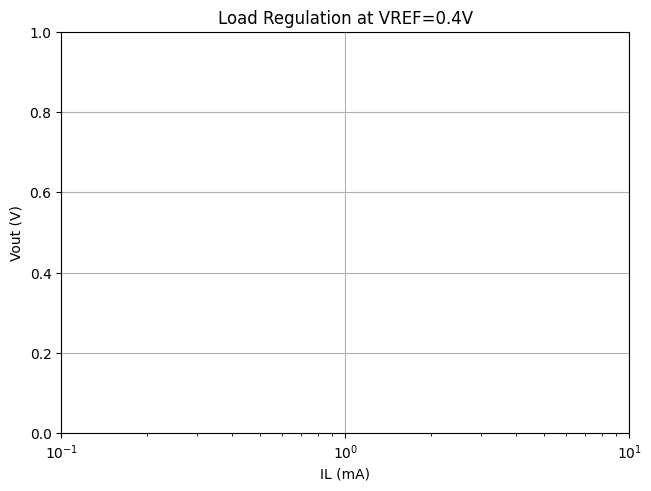

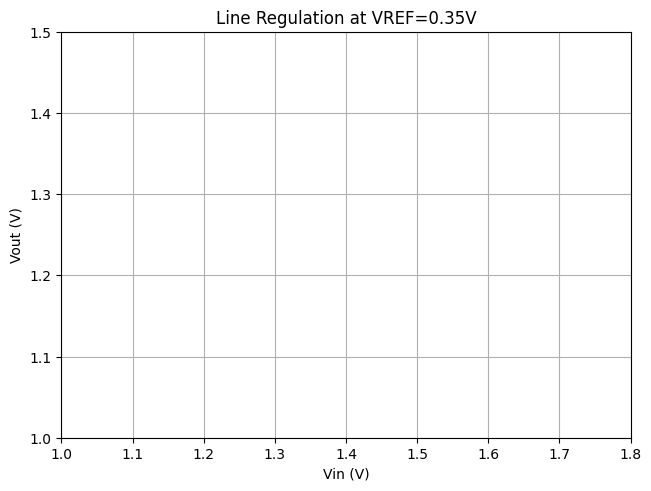

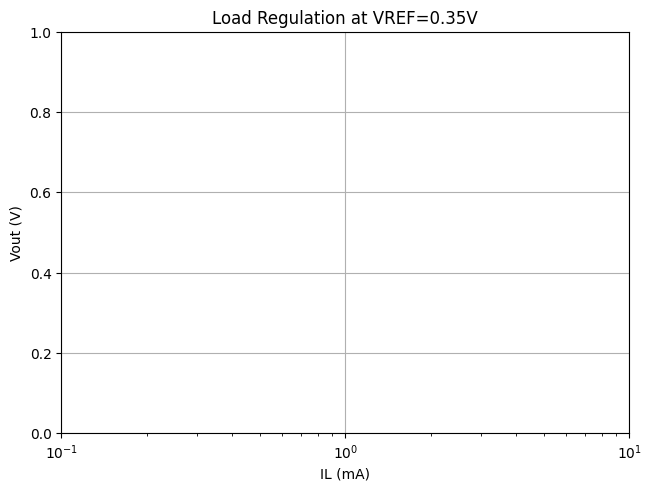

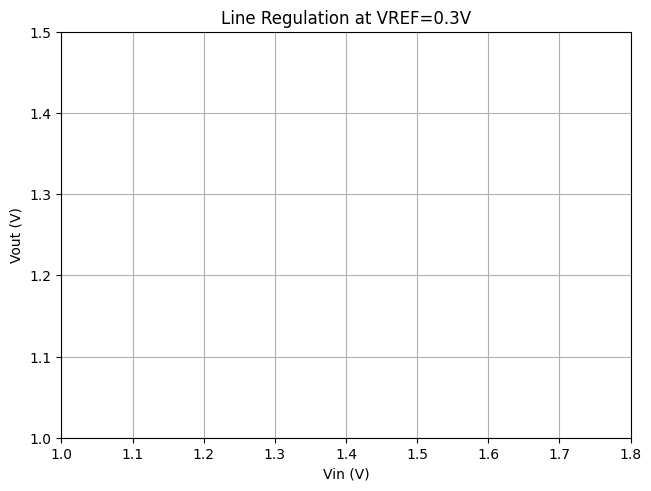

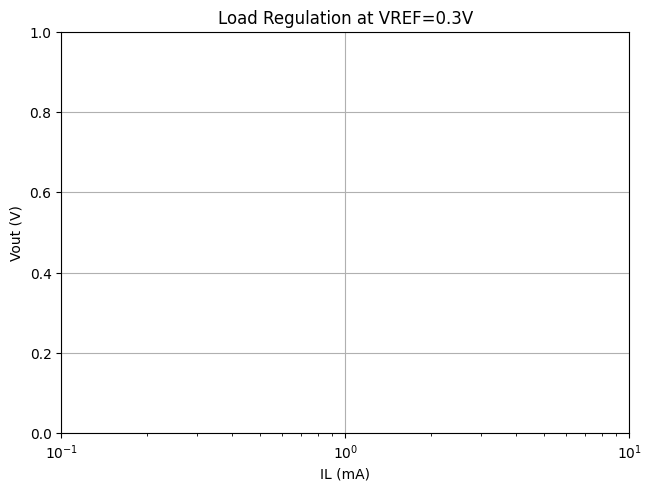

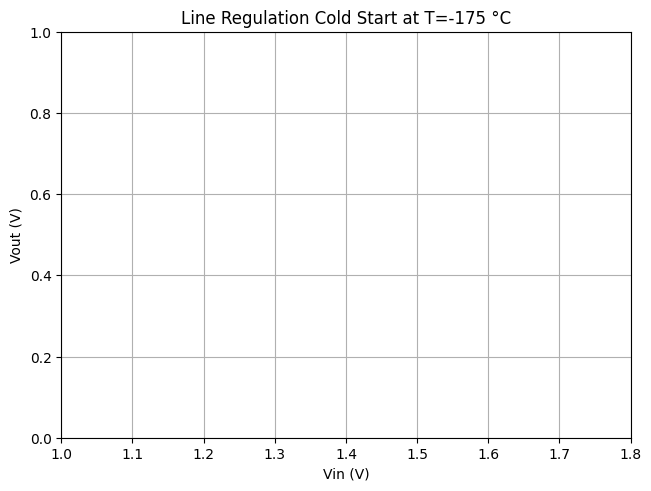

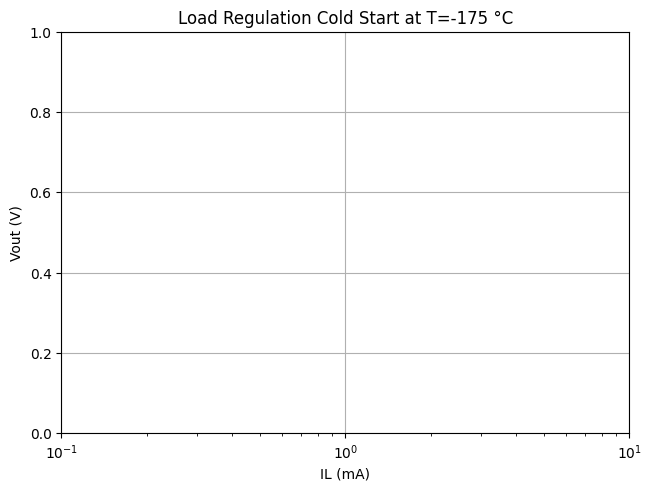

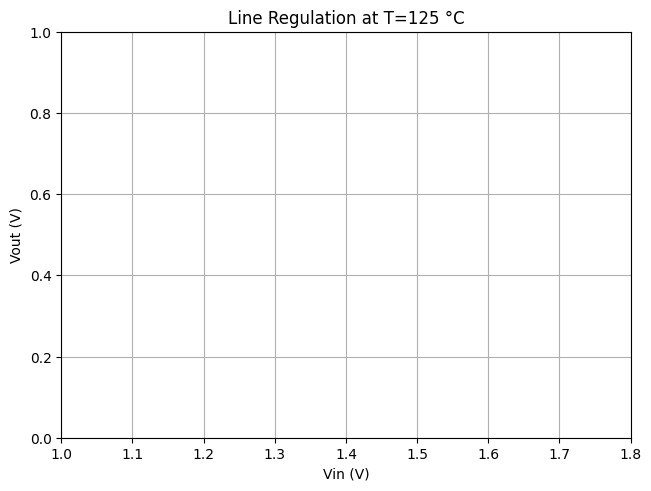

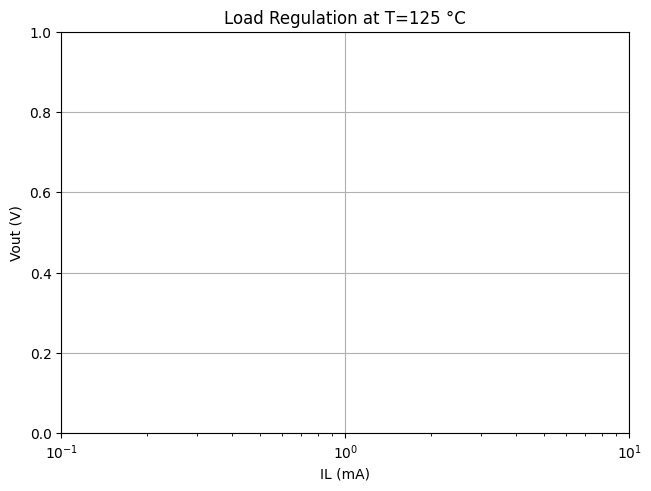

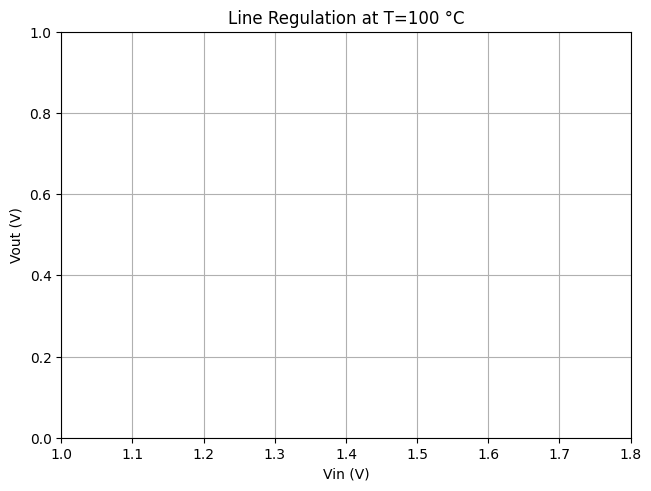

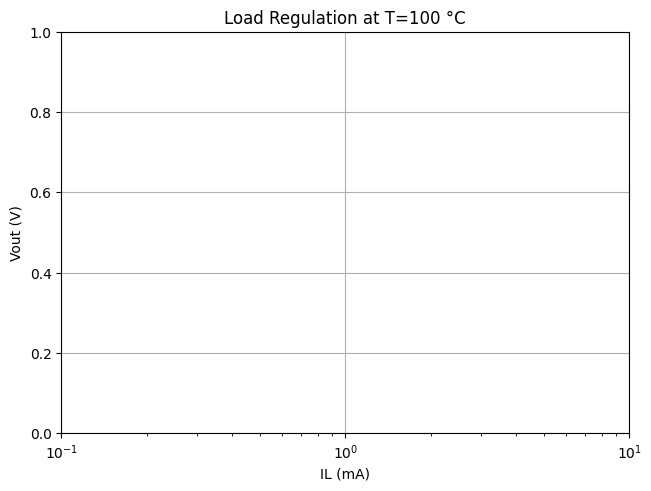

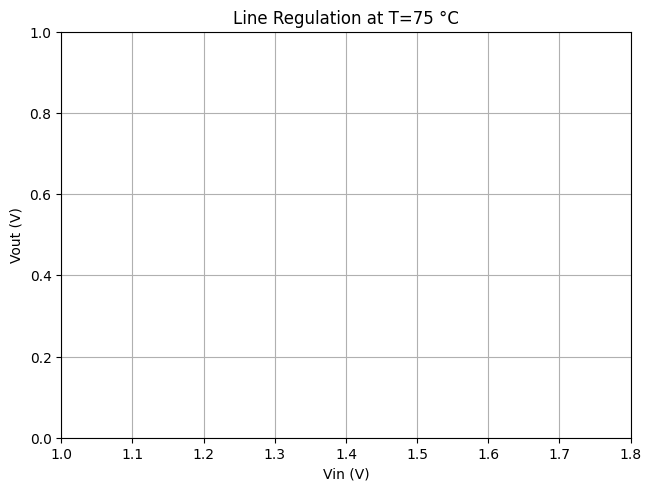

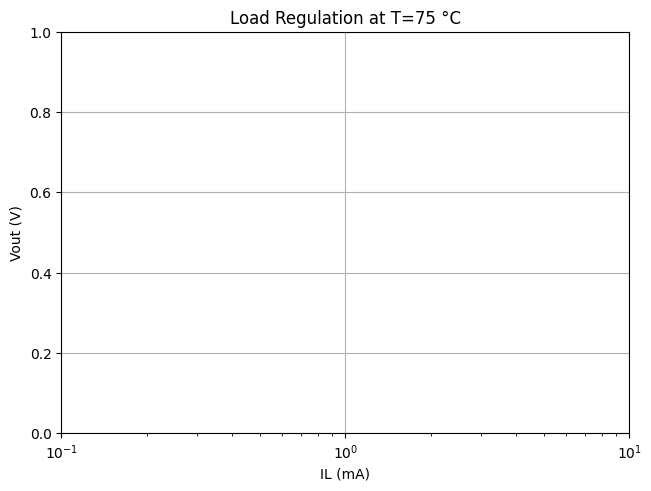

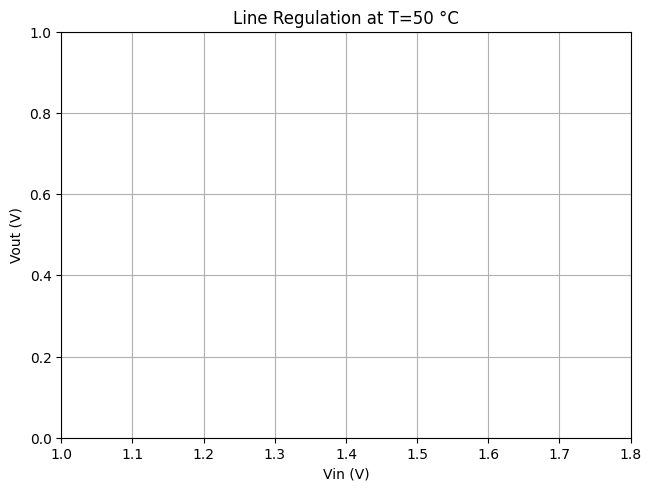

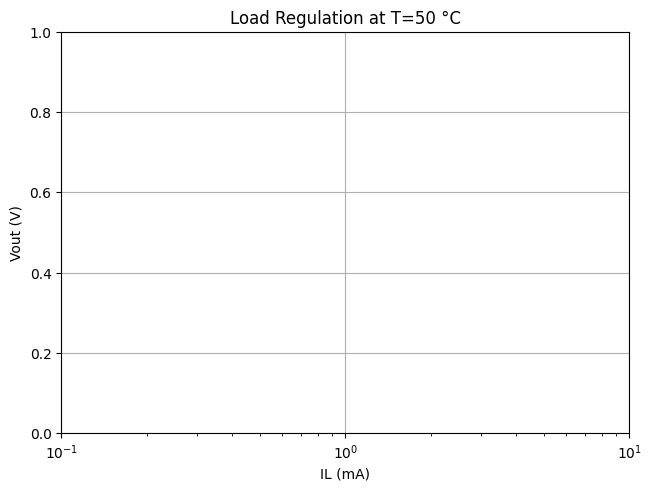

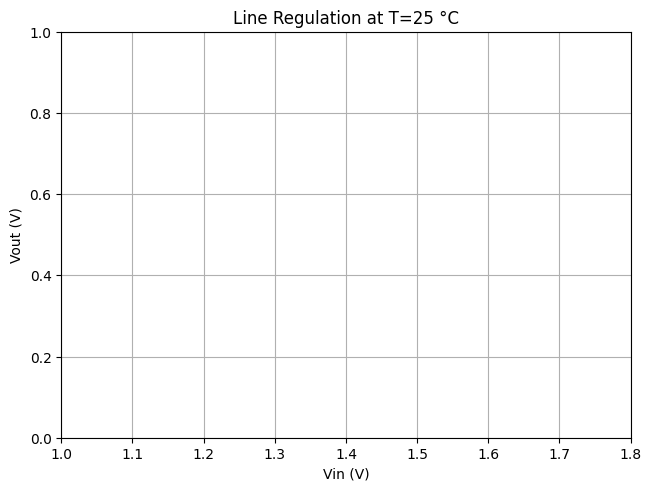

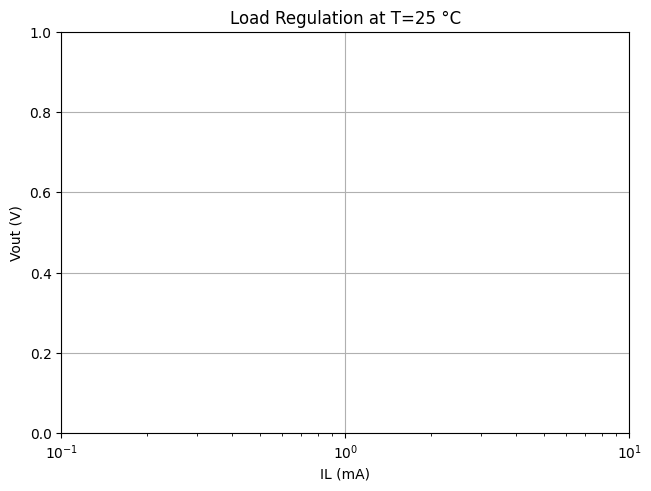

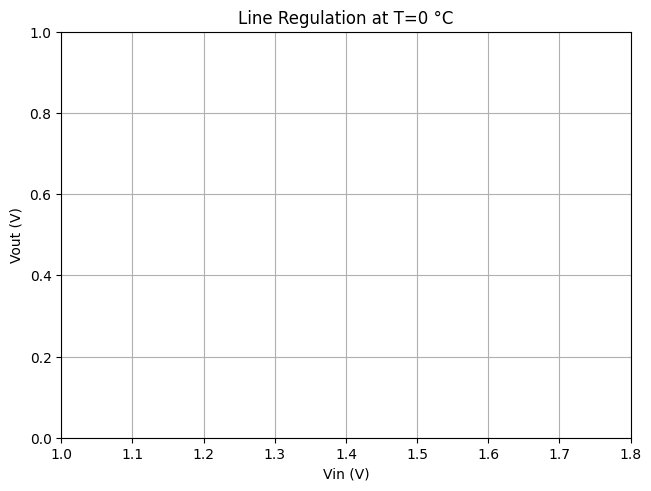

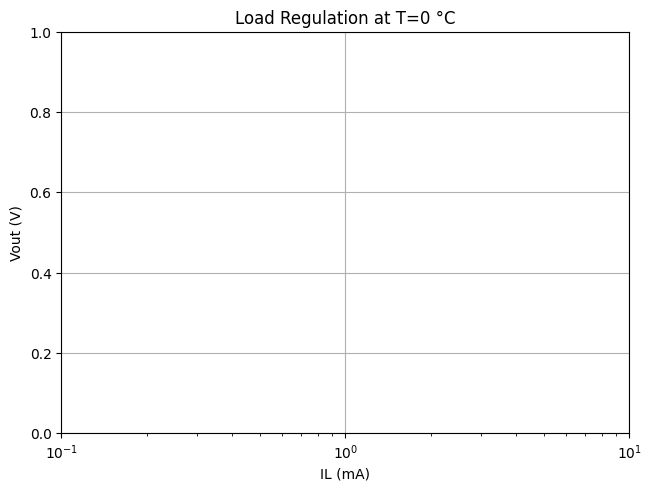

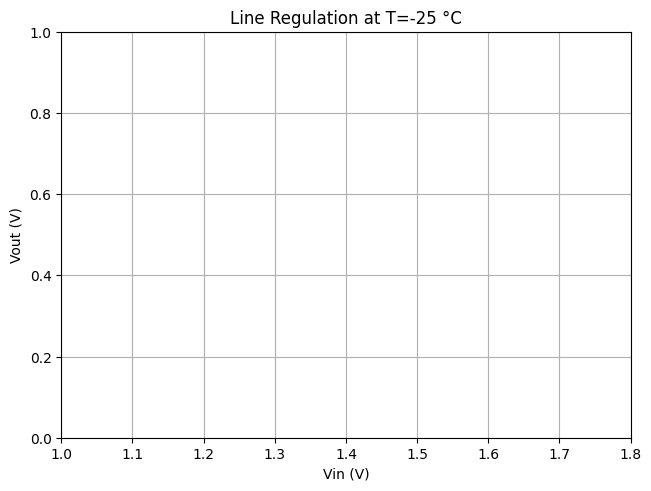

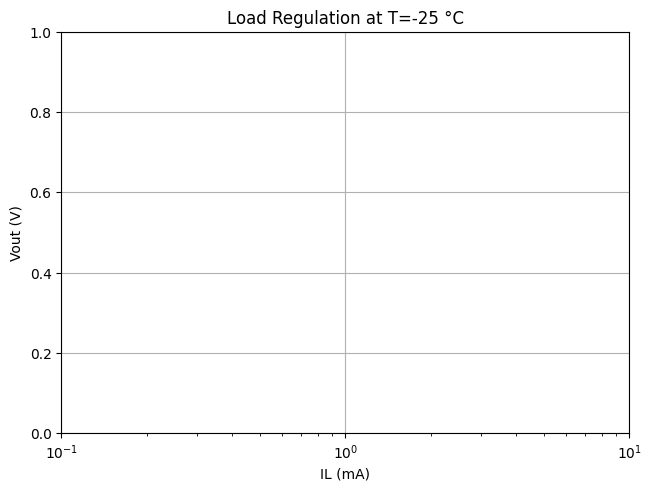

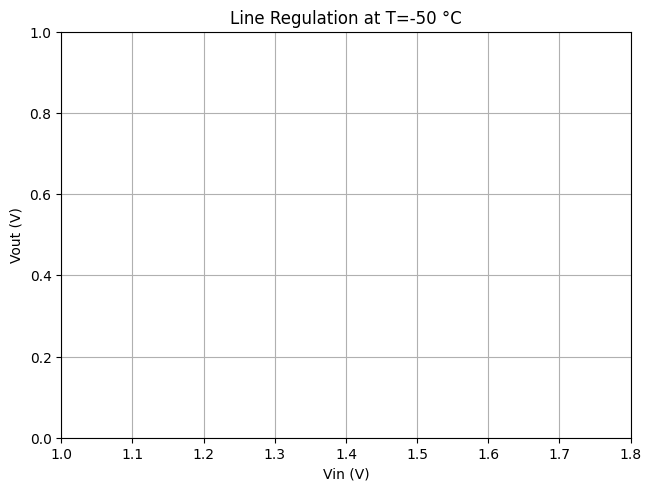

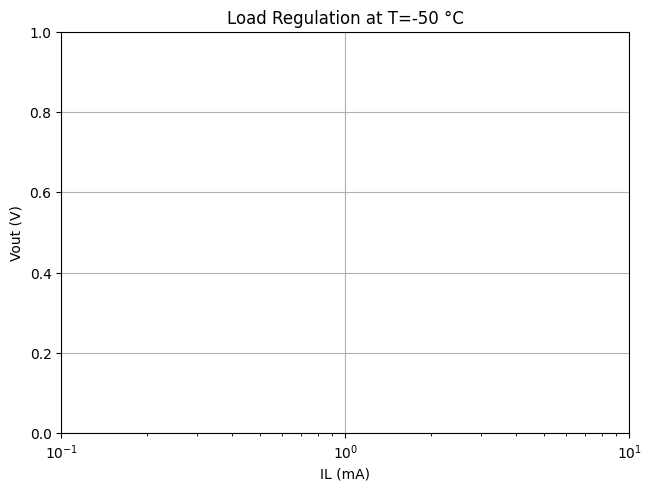

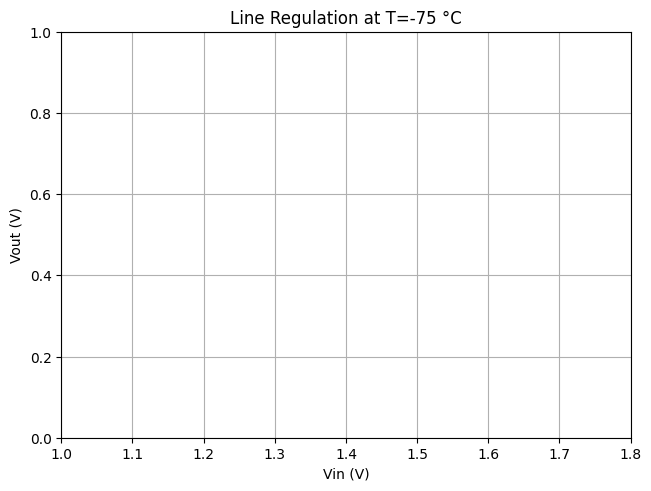

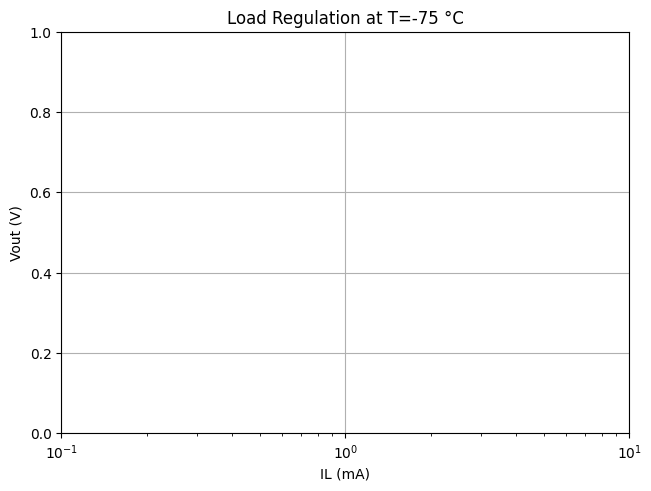

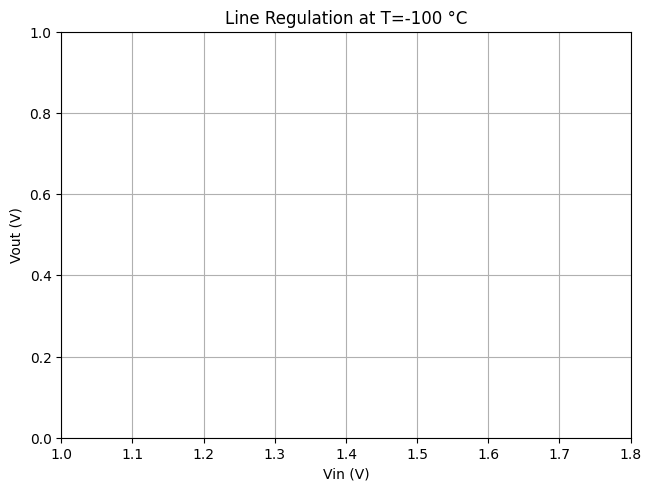

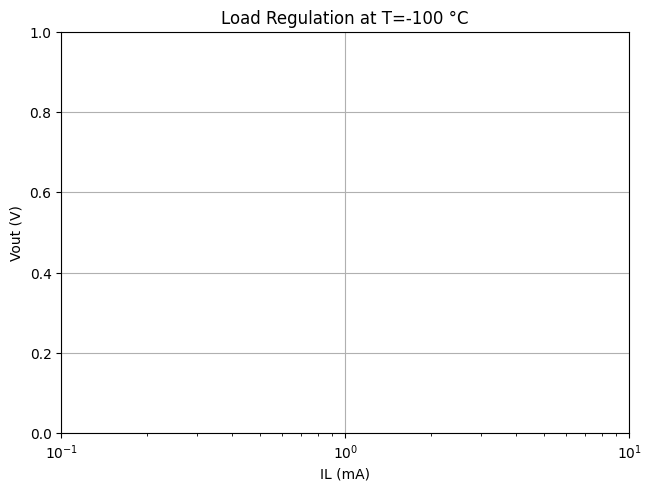

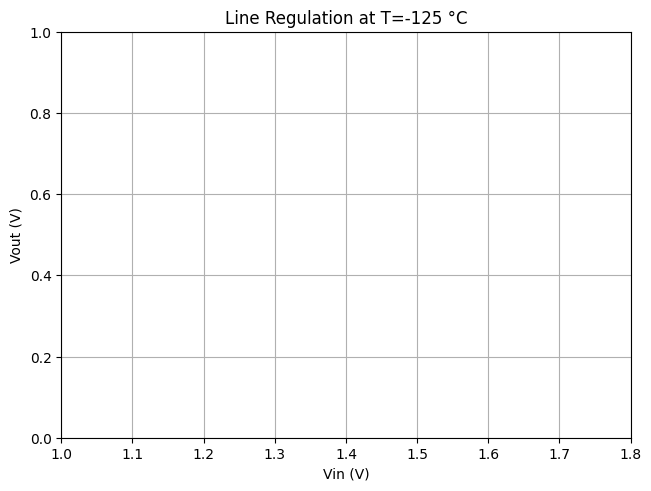

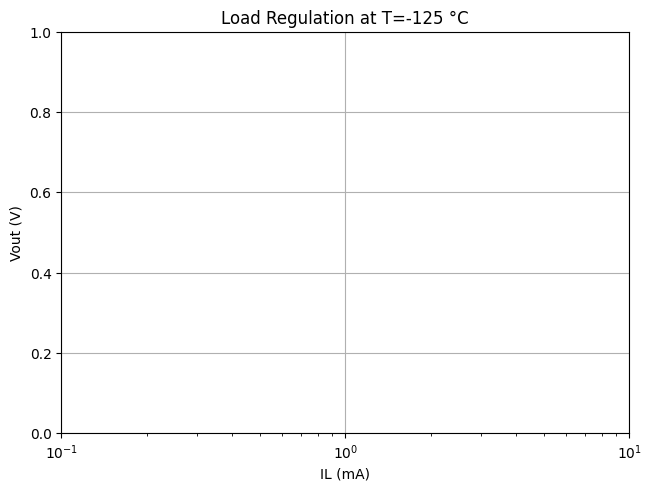

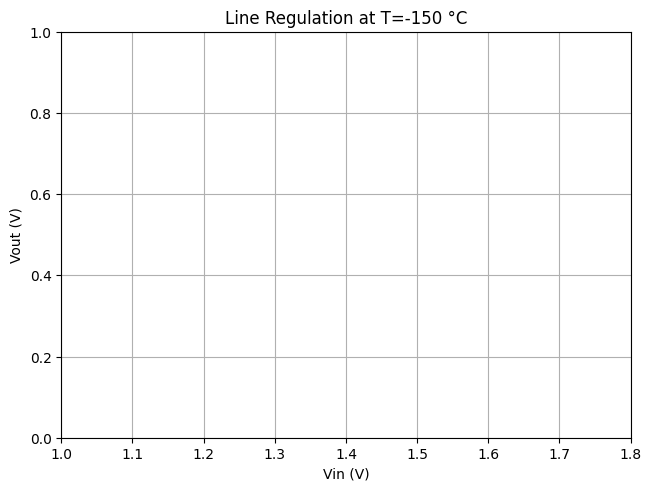

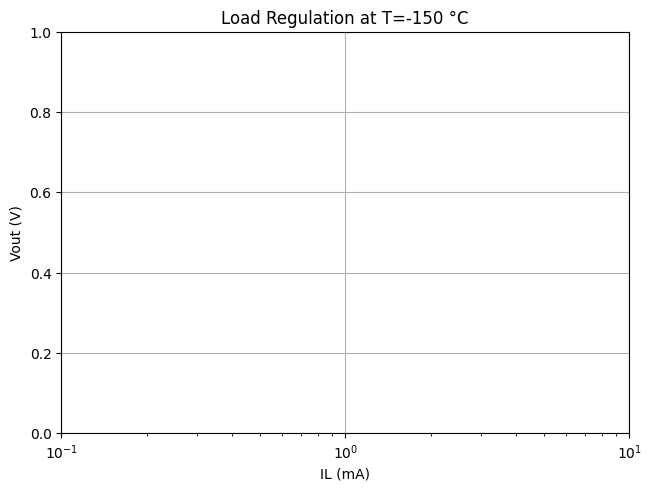

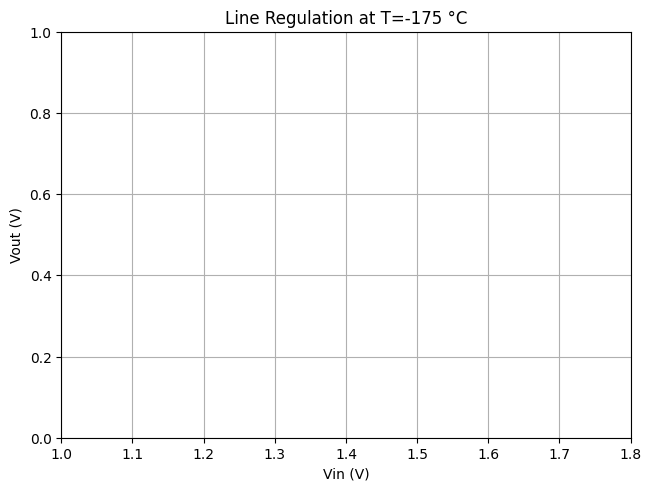

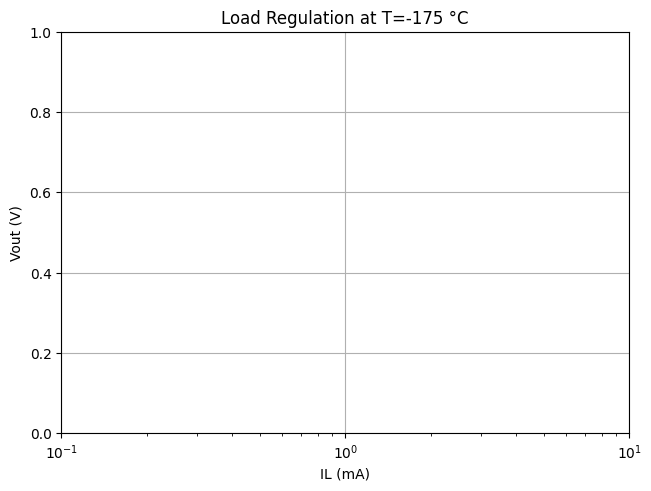

In [ ]:
# Use this to print the formatting of all of your plots - not called during tests
def initialize_all_plots(plot_temps, plot_VREFs):
    dropout_voltage_plot_init()
    voltage_regulation_plot_init()
    for VREF in plot_VREFs:
        line_regulation_plot_init(VREF)
        load_regulation_plot_init(VREF)
        pass
    cold_start_line_regulation_plot_init()
    cold_start_load_regulation_plot_init()
    for temp in plot_temps:
        reverse_line_regulation_plot_init(temp)
        reverse_load_regulation_plot_init(temp)
        pass
    plt.show()

initialize_all_plots(GLOBAL_TEMPS, GLOBAL_VREFS)

<h3>* Generate Experimental Plots </h3>

In [10]:
# Manual use - Not called during procedure

# Missing some results in this directory, so not all temps are included. 
#plot_temps = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, "-175C_Cold_Start"] 
plot_temps = GLOBAL_TEMPS # Manually set
plot_VREFs=ICASL.arange(1.7, 1.4, -.05) # Manually set
print(plot_temps)
print(plot_VREFs)
date = "2025-06-23" # Manually set 
run = "Experiment_5" # Manually set
read_dir = os.path.join(f"{DEVICE_NAME}_Results", date, run) 
write_dir = os.path.join(f"{DEVICE_NAME}_Results", date, run, "Plots_Generated_Later") # Make sure this doesn't overwrite anything important
os.makedirs(write_dir, exist_ok=True)

plot_all_across_temps(read_dir, write_dir, plot_temps, plot_VREFs)
plot_all_reverse(read_dir, write_dir, plot_temps, plot_VREFs)

[125, 100, 75, 50, 25, 0, -25, -50, -75, -100, -125, -150, -175]
[1.7, 1.65, 1.6, 1.55, 1.5, 1.45, 1.4]


<h2> Experimental Procedure </h2>

<h3> Individual Tests </h3>

In [ ]:
def VISET_calc(VREF, IL):
    VOUT = VREF*2
    return -RHI*(IL-VOUT/RLO)+VOUT

# Varies VREF. For each VREF, varies VIN, then IL. 
# Plots Line Regulation and Load Regulation.
# Records the VOUT corresponding to the largest VIN for the Voltage Regulation Plot
# Records calculated Dropout Voltage (from smallest VIN and corresponding VOUT) for the Dropout Voltage Plot
def VIN_test(save_dir, local_VREFs):
    VISETs=[]
    VDOs=[]
    VOUTregs=[]
    for VREF in local_VREFs:                                   
        ####### Sets VISET then VREF #######
        VISET = VISET_calc(VREF, IL_DEFAULT)
        VISETs.append(VISET)
        WG_VREF_VISET.write("SOUR2:APPL:DC DEF, DEF, " + str(VISET))   # Sets VISET to needed value to achieve default IL
        time.sleep(.1)                                                 # Set VISET before VREF because VREF is being swept up. Want to limit current
        WG_VREF_VISET.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF))    # Sets VREF

        ####### Inner Sweeps #######
        ####### Creates Lists for Data #######              
        VINs=[]                                                  
        ITOTs=[] # Stores total current values (IQ + IL)
        VOUTs=[]                                                 
        VDROPs=[]

        ####### Sweep of VIN for default IL #######
        for val in ICASL.arange(VIN_MAX, VIN_MIN, VIN_STEP):  # Loop from VIN_MAX to VIN_MIN (or VREF if its higher) in steps of VIN_STEP                                                                                                
            ####### Sets VIN voltage #######            
            SM_VIN.write("SOUR:VOLT:LEV " + str(val))           # Set VIN
            time.sleep(SETTLING_TIME)                                      
            
            ####### Measure ILOAD and others #######
            VOUTs.append(float(MM_VOUT.query(":READ?")))     
            ITOTs.append(SM_VIN.query(":READ?").split(',')[1])   # Query and append the measured total current through VIN
            VDROPs.append(float(MM_VDROP.query(":READ?")))
            VINs.append(val)                                     # Append VIN to list
        SM_VIN.write(f"SOUR:VOLT:LEV {VIN_DEFAULT}") 

        ####### Store Data #######
        df = pd.DataFrame({'VIN': VINs, 'ITOT': ITOTs, 'VOUT': VOUTs, 'VDROP': VDROPs}) # Create a pandas DataFrame from VIN, ITOT, and VOUT lists
        # I keep these separate just to make sure I don't mess up the file name formatting in future code
        test_name = "VIN_sweep" 
        varied_constant = "VREF"
        csv_path = os.path.join(save_dir, f"{test_name}__{varied_constant}={ICASL.set_precision(VREF, local_VREFs)}.csv") # Generate the file path for saving the CSV
        df.to_csv(csv_path, index=False)                                            # Save the DataFrame to a CSV file without including the index
        
        VDO = VINs[-1] - VOUTs[-1]  # Calculate Dropout Voltage, to be used to generate plot.
        #VDO plot seems to be using the smallest VIN value (max of VIN_MIN, VREF-.1)     
        VDOs.append(VDO)
        VOUTregs.append(VOUTs[0])   
        
    # Restore default VREF and VISET
    WG_VREF_VISET.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF_DEFAULT)) # VREF
    VISET = VISET_calc(VREF_DEFAULT, IL_DEFAULT)            # Restores IL (with VISET)
    WG_VREF_VISET.write("SOUR2:APPL:DC DEF, DEF," + str(VISET))

    # Create an excel file with each VISET value used for each VREF
    df2 = pd.DataFrame({'VREF': local_VREFs, 'VISET': VISETs, 'VDO': VDOs, 'VOUTreg': VOUTregs})
    csv_path = os.path.join(save_dir, "VIN_Sweep_Overall.csv") 
    df2.to_csv(csv_path, index=False)

# Saves IL values and their Vout values for load regulation plot
def IL_test(save_dir, local_VREFs):
    VISETlist = []
    for VREF in local_VREFs:                                   
        ####### Sets VISET then VREF #######
        VISET = VISET_calc(VREF, IL_DEFAULT)
        VISETlist.append(VISET)
        WG_VREF_VISET.write("SOUR2:APPL:DC DEF, DEF, " + str(VISET))   # Sets VISET to needed value to achieve default IL
        time.sleep(.1)                                                 # Set VISET before VREF because VREF is being swept up. Want to limit current
        WG_VREF_VISET.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF))    # Sets VREF
                   
        ITOTs=[] # Stores total current values (IQ + IL)
        VOUTs=[]                                                
        VDROPs=[]
        for IL in GLOBAL_ILS:
            VISET = VISET_calc(VREF, IL)
            WG_VREF_VISET.write(f"SOUR2:APPL:DC DEF, DEF, {VISET}")
            time.sleep(SETTLING_TIME)  
            VOUTs.append(float(MM_VOUT.query(":READ?")))     
            ITOTs.append(SM_VIN.query(":READ?").split(',')[1])   # Not used for any plots yet, saved anyways
            VDROPs.append(float(MM_VDROP.query(":READ?")))       # Not used for any plots yet, saved anyways
        VISET = VISET_calc(VREF, IL_DEFAULT)
        WG_VREF_VISET.write(f"SOUR2:APPL:DC DEF, DEF, {VISET}")
        time.sleep(1) # Source gets stuck at previous current, hopefully this will solve that.
        
        ####### Store Data #######
        df = pd.DataFrame({'IL': GLOBAL_ILS, 'ITOT': ITOTs, 'VOUT': VOUTs, 'VDROP': VDROPs}) # Create a pandas DataFrame from lists
        test_name = "IL_sweep"
        varied_constant = "VREF"
        csv_path = os.path.join(save_dir, f"{test_name}__{varied_constant}={VREF:.{ICASL.determine_precision(local_VREFs)}f}.csv")                      
        df.to_csv(csv_path, index=False)
        
print("Initialized Individual Tests")

<h3> Full Procedure </h3>

In [ ]:
#####################################################################################################################
################## IMPORTANT: Make sure all CHAMBER commands are contained with an if(USE_CHAMBER): #################
#####################################################################################################################

# USE_CHAMBER = True - turns on the temperature chamber and performs the temperature sweep
# USE_CHAMBER = False - performs a test run without interacting with the chamber.

def run_experiment(USE_CHAMBER, RUN_TYPE, local_temps=GLOBAL_TEMPS, local_VREFs=GLOBAL_VREFS):
    # Create file path
    DATE_DIR =  str(date.today())
    i = 1
    RUN_DIR =  os.path.join(f"{DEVICE_NAME}_Results", f"{DATE_DIR}", f"{RUN_TYPE}_{i}")
    while (os.path.isdir(RUN_DIR) == True) and (len(os.listdir(RUN_DIR)) != 0) : # Checks if directory name is taken, updates run number until it is not. Makes sure directory isn't empty.
        i = i+1
        RUN_DIR =  os.path.join(f"{DEVICE_NAME}_Results", f"{DATE_DIR}", f"{RUN_TYPE}_{i}")
    RUN_DIR_ONCE_PLOTTED = RUN_DIR
    RUN_DIR = RUN_DIR + "_No_Plots"        
    os.makedirs(RUN_DIR, exist_ok=True)  # If the directory already exists, it won't raise an error due to exist_ok=True
    
    ################## Initialize Equipment ##################
    
    if (USE_CHAMBER):
        chamber_init()
    initialize_all() 
    turn_on_all()
    
    ################## Temperature Sweep ##################
    
    temps_tested = []        
    for temp in local_temps:
        TEMP_DIR = os.path.join(RUN_DIR, f"temp={temp}")    # The temperature of the experiment gets set as the sub directory name
        os.makedirs(TEMP_DIR, exist_ok=True) # Create a directory with the given name. If the directory already exists, it won't raise an error due to exist_ok=True

        if (USE_CHAMBER): 
            user_probe_temp = CHAMBER.query("USER?")
            if (temp < -150 and user_probe_temp < -100):
                CHAMBER.write("RATE=10")     # Slow chamber's rate of change. Hopefully this will result in less LN2 spillage and less overshoot.
                CHAMBER.write("HOFF")        # Stops chamber from heating. We've had issues with it applying a little heat at -175 and rapidly dropping the DUT temp.
            CHAMBER.write(f"SET={temp}")
            while(True):
                time.sleep(.5)
                measure_all() # Updates multimeters periodically during time between tests
                time.sleep(10)
                #print(CHAMBER.query("STATUS?"))
                user_probe_temp = CHAMBER.query("USER?")
                if (temp+SET_PRECISION >= float(user_probe_temp) >= temp-SET_PRECISION):
                    break
            print(CHAMBER.query("STATUS?"))
            time.sleep(SOAK_TIME)  

        VIN_test(TEMP_DIR, local_VREFs)
        IL_test(TEMP_DIR, local_VREFs)

        temps_tested.append(temp)
        plot_all_across_temps(RUN_DIR, TEMP_DIR, temps_tested, local_VREFs) # Intermediate plots

        # Changes name of run directory once some plots are in it.
        os.rename(RUN_DIR, RUN_DIR_ONCE_PLOTTED)
        RUN_DIR = RUN_DIR_ONCE_PLOTTED
    
    # Overall plots
    FINAL_PLOTS_DIR = os.path.join(RUN_DIR, "Final_Plots")
    os.makedirs(FINAL_PLOTS_DIR, exist_ok=True)
    plot_all_across_temps(RUN_DIR, FINAL_PLOTS_DIR, local_temps, local_VREFs)

    ##################### Cold Start #####################
    
    turn_off_all()       # Turn off voltages
    if (USE_CHAMBER):
        time.sleep(900)  # Wait 15 minutes for device to cool down
    else:
        time.sleep(5)    # I feel like it's a bad idea to rapidly turn everything off then on, so here's a short wait
    turn_on_all()

    RUN_DIR_CS = os.path.join(RUN_DIR, "Cold_Start")
    TEMP_DIR_CS = os.path.join(RUN_DIR_CS, "temp=-175")
    os.makedirs(TEMP_DIR_CS, exist_ok=True)
    
    VIN_test(TEMP_DIR_CS, local_VREFs)
    IL_test(TEMP_DIR_CS, local_VREFs)
    
    plot_all_cold_start(RUN_DIR_CS, TEMP_DIR_CS, local_VREFs)

    turn_off_all()       # Temperature Chamber is NOT off at this point. Close valve, let the pipes empty, then set it back to room temp.

print("Initialized Full Procedure")

<h3>* Inputs for Running Experiment</h3>

In [4]:
# To be safe you should run this every time earlier code is changed - it's easy to forget to run a definition after altering it.
execute_cells_by_tag('init') 

Imported Libraries
ICASL is loaded!
Initialized Constants:
VIN: [1.8, 1.775, 1.75, 1.725, 1.7, 1.675, 1.65, 1.625, 1.6, 1.575, 1.55, 1.525, 1.5, 1.475, 1.45, 1.425, 1.4, 1.375, 1.35, 1.325, 1.3, 1.275, 1.25, 1.225, 1.2, 1.175, 1.15, 1.125, 1.1, 1.075, 1.05, 1.025, 1.0]
VREF: [0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3]
VREF Precision: 2
[ 0.1  0.3  0.5  1.   2.   3.   4.   5.   6.   7.   8.   9.  10. ]
0.8
Initialized Equipment's Establish Connection
Initialized Equipment Functions
Initialized Plotting Default Styling
Initialized Specific Plots
Initialized Individual Tests
Initialized Full Procedure


In [ ]:
turn_on_all()

In [ ]:
measure_all()

In [ ]:
# You'll need to run this every time you stop mid-test
turn_off_all()

In [ ]:
# PRACTICE Run, chamber not affected

# Change this if you do a practice run at another temp. For file labeling purposes, doesn't actually set the temp.
practice_temperature = "27"
pr_default = f"Practice_Run_{practice_temperature}°C"
# Can make this one any string you want, really.
pr_name = pr_default        

run_experiment(False, pr_name, local_temps=practice_temperature)

In [ ]:
#
# Buffer so we don't misclick
#

In [ ]:
# ACTUAL Run, chamber sweeps temperature

local_temps = GLOBAL_TEMPS # Can change this to any list of temps. Ex: [0, 27, 50]. Runs in order.
local_VREFs = GLOBAL_VREFS
# CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED
run_experiment(True, "Experiment", local_temps=local_temps, local_VREFs=local_VREFs) # CHAMBER IS USED
# CHAMBER IS USED # CHAMBER IS USED # CHAMBER IS USED# CHAMBER IS USED# CHAMBER IS USED

In [ ]:
# Return to room temperature
# TURN VALVE AND WAIT FIRST
CHAMBER.write("HON")
CHAMBER.write("COFF")
CHAMBER.write("RATE=20")
CHAMBER.write("SET=25")